In [101]:
# %pip install torch
# %pip install captum

In [2]:
# Initial imports
import numpy as np
import torch
import torch.nn as nn
import captum
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [3]:
# Update path to dataset here.
dataset_path = "titanic.csv"

In [4]:
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

In [5]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Con los datos cargados, ahora preprocesamos los datos convirtiendo algunas características categóricas como el género, la ubicación del embarque y la clase de pasajero en codificaciones únicas (columnas de características separadas para cada clase con 0/1). 
También eliminamos algunas características que son más difíciles de analizar, como el nombre, y completamos los valores faltantes en la edad y la tarifa con los valores promedio.

En este caso, cada categoría en cada columna se convertirá en un número entero único. Sin embargo, ten en cuenta que si hay una relación ordinal entre las categorías, como en el caso de "Pclass" (clase de pasajero), podría ser más apropiado utilizar el enfoque de variables ficticias (dummy variables) para evitar la interpretación errónea de un orden implícito.

Al final, la elección entre LabelEncoder y el enfoque de variables ficticias depende del contexto y la naturaleza de tus datos. Si no hay un orden implícito entre las categorías y el modelo de aprendizaje automático que utilizarás puede manejar variables categóricas codificadas de manera ordinal, LabelEncoder puede ser una opción adecuada. Sin embargo, si las categorías no tienen un orden natural o el orden puede introducir sesgos, es preferible utilizar el enfoque de variables ficticias.

In [7]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex'], dtype=int),
                          pd.get_dummies(titanic_data['Embarked'],prefix="Embark", dtype=int),
                          pd.get_dummies(titanic_data['Pclass'],prefix="Class", dtype=int)], axis=1)

titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())

titanic_data = titanic_data.drop(['PassengerId', 'Name','Ticket','Sex','Embarked','Pclass', 'Cabin'], axis=1)

In [8]:
titanic_data.head()

,Survived,Age,SibSp,Parch,Fare,female,male,Embark_C,Embark_Q,Embark_S,Class_1,Class_2,Class_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [9]:
titanic_data.shape

(891, 13)

In [10]:
# Guardamos el DataFrame en un archivo CSV
titanic_data.to_csv('titanic_data.csv', index = False)

Después del procesamiento, las características que tenemos son:

Age  - Edad del Pasajero  
Sibsp - Número de hermanos/cónyuges a bordo  
Parch - Número de padres/hijos a bordo  
Fare  - Importe de tarifa pagado en libras esterlinas  
Female  - Variable binaria que indica si el pasajero es mujer  
Male  - Variable binaria que indica si el pasajero es hombre  
EmbarkC - Variable binaria que indica si el pasajero se embarcó en Cherburgo  
EmbarkQ: variable binaria que indica si el pasajero se embarcó en Queenstown  
EmbarkS - Variable binaria que indica si el pasajero se embarcó en Southampton  
Class1 - Variable binaria que indica si el pasajero estaba en primera clase  
Class2 - Variable binaria que indica si el pasajero estaba en segunda clase  
Class3 - Variable binaria que indica si el pasajero estaba en tercera clase  

Ahora convertimos los datos en matrices numpy y separamos los conjuntos de entrenamiento y prueba.

In [11]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["Survived"].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

In [12]:
train_features.shape

(623, 12)

Ahora estamos listos para definir la arquitectura de la red neuronal que usaremos para la tarea.  Hemos definido una arquitectura simple utilizando 2 capas ocultas, la primera con 12 unidades ocultas y la segunda con 8 unidades ocultas, cada una con no linealidad sigmoide.  La capa final realiza una operación softmax y tiene 2 unidades, correspondientes a las salidas de sobrevivido (1) o no sobrevivido (0).

In [13]:
torch.manual_seed(1)  # Set seed for reproducibility.

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))
    
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()
            
        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        return predicted_probs


    
    def predict_lime(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        elif isinstance(x, torch.Tensor):
            x = x.float()

        x = x.view(x.size(0), -1)
        output = self.forward(x)
        predicted_probs = torch.softmax(output, dim=1)
        _, predicted_labels = torch.max(predicted_probs, 1)
        return predicted_probs.detach().numpy()
    
# Declaramos una nueva instancia de clase
net = TitanicSimpleNNModel()

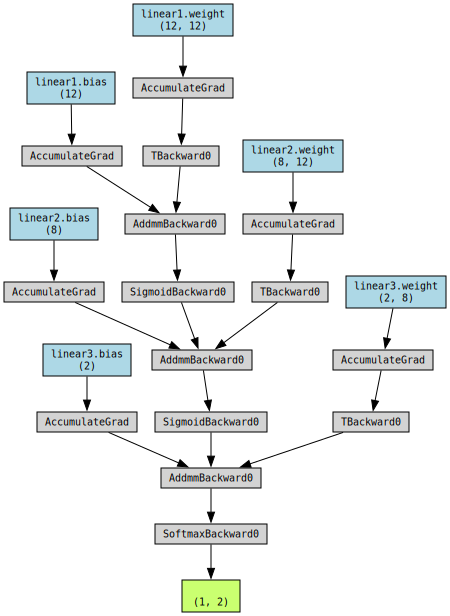

In [16]:
pip install torchviz
from torchviz import make_dot

# Crear una instancia de tu modelo
net = TitanicSimpleNNModel()

# Generar un tensor de ejemplo para visualizar el gráfico
dummy_input = torch.randn(1, 12)

# Visualizar el gráfico computacional del modelo
make_dot(net(dummy_input), params=dict(net.named_parameters()))

Podemos usar un modelo previamente entrenado o entrenar la red usando los datos de entrenamiento para 200 épocas. Tenga en cuenta que los resultados de los pasos posteriores pueden no coincidir si se vuelve a entrenar. 

In [114]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('titanic_model.pt'))
    print("Model Loaded!")

    input_tensor = torch.from_numpy(train_features).type(torch.BoolTensor)  # Para convertir datos booleanos
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor) # Para convertir datos enteros

    input_tensor = torch.from_numpy(train_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
    label_tensor = torch.from_numpy(train_labels)
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

    # input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)

    input_tensor = torch.from_numpy(train_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
    label_tensor = torch.from_numpy(train_labels)

    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'titanic_fcnn.pt')

Epoch 1/200 => Loss: 0.73
Epoch 21/200 => Loss: 0.53
Epoch 41/200 => Loss: 0.49
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.47
Epoch 121/200 => Loss: 0.47
Epoch 141/200 => Loss: 0.47
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47


In [115]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8346709470304976


In [116]:
# test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
test_input_tensor = torch.from_numpy(test_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos

out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8134328358208955


* Probamos el método "predict_lime" de la clase "TitanicSimpleNNModel"

In [117]:
single_input = test_input_tensor[0].unsqueeze(0)
predict = net.predict_lime(single_input)
print( 'Prediction: ',predict, 'Input size: ', single_input.shape)

Prediction:  [[0.73105633 0.26894373]] Input size:  torch.Size([1, 12])


In [118]:
multiple_input = test_input_tensor[:10]
predict = net.predict_lime(multiple_input)
print( 'Prediction: ',predict, 'Input size: ', multiple_input.shape)

Prediction:  [[0.73105633 0.26894373]
 [0.52732056 0.47267947]
 [0.731056   0.268944  ]
 [0.26898634 0.7310137 ]
 [0.7310548  0.26894525]
 [0.73087317 0.26912677]
 [0.693822   0.306178  ]
 [0.2713691  0.7286309 ]
 [0.2690988  0.7309011 ]
 [0.7310555  0.26894453]] Input size:  torch.Size([10, 12])


In [119]:
single_input = test_input_tensor[0].unsqueeze(0)
predict = net.predict(single_input)
print( 'Prediction: ',predict, 'Input size: ', single_input.shape)

Prediction:  tensor([[0.7311, 0.2689]], grad_fn=<SoftmaxBackward0>) Input size:  torch.Size([1, 12])


In [120]:
input = test_input_tensor[:10]
predict = net.predict(input)
print( 'Prediction: ',predict, 'Input size: ', input.shape)

Prediction:  tensor([[0.7311, 0.2689],
        [0.5273, 0.4727],
        [0.7311, 0.2689],
        [0.2690, 0.7310],
        [0.7311, 0.2689],
        [0.7309, 0.2691],
        [0.6938, 0.3062],
        [0.2714, 0.7286],
        [0.2691, 0.7309],
        [0.7311, 0.2689]], grad_fn=<SoftmaxBackward0>) Input size:  torch.Size([10, 12])


Visualizamos el modelo que vamos a almacenar en un archivo para poder utilizarlo sin tener que recrear todo el proceso en otro archivo

In [121]:


# Cargamos el modelo para comprobar que se ha guardado con sus características 
model = TitanicSimpleNNModel()

# Cargar los pesos del modelo desde el archivo
model.load_state_dict(torch.load('titanic_fcnn.pt'))

# Asegurarse de que el modelo esté en modo de evaluación (si corresponde)
model.eval()


TitanicSimpleNNModel(
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (sigmoid1): Sigmoid()
  (linear2): Linear(in_features=12, out_features=8, bias=True)
  (sigmoid2): Sigmoid()
  (linear3): Linear(in_features=8, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)